In [50]:
import pandas as pd 
import statsmodels.tsa as tsa
import statsmodels.api as sm
import matplotlib
import pylab

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
data=pd.read_csv('../csv_data/durham_training.csv')

#data=data.loc[:365]

#defining date_received as a datetime field in pandas
data['date_received'] = pd.to_datetime(data['date_received'])

#Defining date_received as index
data.index=data['date_received']
data.columns

Index(['date_received', 'citizen_init_count', 'officer_init_count',
       'year_received', 'month_received', 'week_received', 'day_received',
       'dow_received', 'apparentTemperatureMax', 'apparentTemperatureMin',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'moonPhase',
       'precipAccumulation', 'precipIntensity', 'precipIntensityMax',
       'precipProbability', 'precipType', 'pressure', 'temperatureMax',
       'temperatureMin', 'visibility', 'windBearing', 'windSpeed',
       'daylightSeconds', 'apparentTemperatureMax_ln',
       'apparentTemperatureMax_quartile', 'apparentTemperatureMax_binary',
       'apparentTemperatureMin_ln', 'apparentTemperatureMin_quartile',
       'apparentTemperatureMin_binary', 'cloudCover_ln', 'cloudCover_quartile',
       'cloudCover_binary', 'dewPoint_ln', 'dewPoint_quartile',
       'dewPoint_binary', 'humidity_ln', 'humidity_quartile',
       'humidity_binary', 'moonPhase_ln', 'moonPhase_quartile',
       'moonPhase_binary', 'precipIn

In [3]:
#Creating constant column for model intercept
data['constant']=1

#Dummy Variable for DOW
dow_dummies=pd.get_dummies(data['dow_received'], prefix='dow')
dow_columns=list(dow_dummies.columns.values)
data=data.join(dow_dummies, how='left')

#Dummy Variable for month
month_dummies=pd.get_dummies(data['month_received'], prefix='month')
month_columns=list(month_dummies.columns.values)

data=data.join(month_dummies, how='left')

#Dummy Variable for TMAX_CAT
tmax_dummies=pd.get_dummies(data['apparentTemperatureMax_quartile'], prefix='tmax')
tmax_columns=list(tmax_dummies.columns.values)
data=data.join(tmax_dummies, how='left')

#Interaction Column
data['pressure_wind']=data['pressure_ln']*data['windSpeed']

In [4]:
glm_vars=['constant', 'christmas', 'thanksgiving', 'humidity', 'pressure_ln', 'temperatureMax_ln', 'windSpeed','pressure_wind']
glm_vars=glm_vars+dow_columns[:-1]+month_columns[:-1]+tmax_columns[:-1]

In [5]:
glm_vars

['constant',
 'christmas',
 'thanksgiving',
 'humidity',
 'pressure_ln',
 'temperatureMax_ln',
 'windSpeed',
 'pressure_wind',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'tmax_1',
 'tmax_2',
 'tmax_3']

In [6]:
#Fitting GLM model
mod = sm.OLS(data['citizen_init_count'], data[glm_vars])
reg =mod.fit()

In [7]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:     citizen_init_count   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     113.0
Date:                Fri, 02 Oct 2015   Prob (F-statistic):               0.00
Time:                        13:06:16   Log-Likelihood:                -14316.
No. Observations:                2891   AIC:                         2.869e+04
Df Residuals:                    2863   BIC:                         2.886e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
constant          -5422.8674   1770.99

In [8]:
#Creating dataframe for timeseries portion fitting
for_ts=pd.DataFrame()
for_ts['glm_resid']=reg.resid
for_ts['count']=data['citizen_init_count']
for_ts['glm_value']=reg.fittedvalues
for_ts['week']=data['week_received']
for_ts['month']=data['month_received']
for_ts['year']=data['year_received']

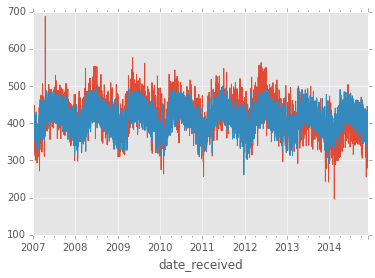

In [9]:
#Predicted glm vs. actuals
for_ts['count'].plot()
for_ts['glm_value'].plot()

In [11]:
#Fitting (1,1) ARMA Model on ARMA residuals
ts_model = tsa.arima_model.ARMA(for_ts['glm_resid'], (2,1))
ts_model_fit=ts_model.fit()

In [12]:
ts_model_fit.params

const             -5.273929
ar.L1.glm_resid    1.104241
ar.L2.glm_resid   -0.106164
ma.L1.glm_resid   -0.961925
dtype: float64

In [13]:
#Adding ARMA model outputs to df
for_ts['ts_value']=ts_model_fit.fittedvalues
#for_ts['ts_resid']=ts_model_fit.resid

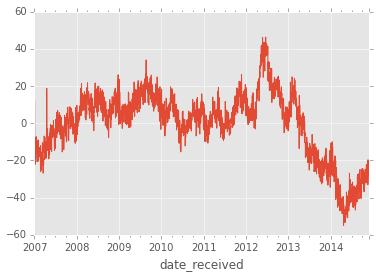

In [14]:
#Plot of AMRA Adjustments
for_ts['ts_value'].plot()

In [15]:
#final prediction and final error
for_ts['final_prediction']=for_ts['glm_value']+for_ts['ts_value']
for_ts['final_resid']=for_ts['count']-for_ts['final_prediction']

In [16]:
#Daily MAPEs
for_ts['glm_mape']=abs((for_ts['count']-for_ts['glm_value'])/for_ts['count'])
for_ts['final_mape']=abs((for_ts['count']-for_ts['final_prediction'])/for_ts['count'])

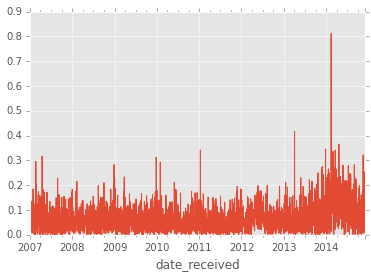

In [17]:
for_ts['glm_mape'].plot()


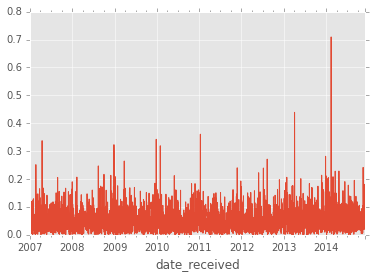

In [18]:
for_ts['final_mape'].plot()

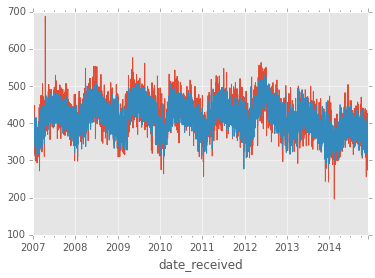

In [19]:
#Actuals vs. predicted
for_ts['count'].plot()
for_ts['final_prediction'].plot()


In [20]:
#MAPE after GLM
sum(for_ts['glm_mape'])/len(for_ts['glm_mape'])*100

6.5297296009095698

In [21]:
#MAPE after GLM + ARMA
sum(for_ts['final_mape'])/len(for_ts['glm_mape'])*100

5.4930111631143363

In [22]:
sorted_df=for_ts.sort('final_mape', ascending=False)

In [23]:
#Days model was worst on
sorted_df[0:20]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2014-02-13,-159.085737,196,355.085737,7,2,2014,-20.089971,334.995765,-138.995765,0.811662,0.709162
2013-04-03,-121.984788,292,413.984788,14,4,2013,6.179222,420.164010,-128.164010,0.417756,0.438918
2011-01-11,-87.819864,257,344.819864,2,1,2011,4.826751,349.646615,-92.646615,0.341712,0.360493
2009-12-26,-97.759328,312,409.759328,52,12,2009,9.009428,418.768757,-106.768757,0.313331,0.342208
2007-04-16,217.521623,687,469.478377,16,4,2007,-14.186931,455.291446,231.708554,0.316625,0.337276
2008-12-26,-88.835548,335,423.835548,52,12,2008,19.337818,443.173366,-108.173366,0.265181,0.322906
2010-01-30,-81.290538,277,358.290538,4,1,2010,7.080399,365.370936,-88.370936,0.293468,0.319029
2008-12-27,-94.082625,333,427.082625,52,12,2008,3.440731,430.523356,-97.523356,0.282530,0.292863
2013-12-27,-109.728493,317,426.728493,52,12,2013,-20.529869,406.198625,-89.198625,0.346147,0.281384


In [24]:
#Days model was best on
sorted_df[-20:]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2009-01-29,4.689714,388,383.310286,5,1,2009,4.833811,388.144098,-0.144098,0.012087,0.000371
2010-08-29,3.226783,392,388.773217,34,8,2010,3.092663,391.865880,0.134120,0.008232,0.000342
2007-04-06,-13.142332,423,436.142332,14,4,2007,-13.005529,423.136803,-0.136803,0.031069,0.000323
2013-03-22,4.181007,426,421.818993,12,3,2013,4.314281,426.133274,-0.133274,0.009815,0.000313
2014-03-07,-35.317564,359,394.317564,10,3,2014,-35.206638,359.110926,-0.110926,0.098378,0.000309
2013-07-20,-21.576529,435,456.576529,29,7,2013,-21.710370,434.866160,0.133840,0.049601,0.000308
2010-09-16,-4.374056,443,447.374056,37,9,2010,-4.239614,443.134442,-0.134442,0.009874,0.000303
2011-12-12,12.730974,404,391.269026,50,12,2011,12.849918,404.118943,-0.118943,0.031512,0.000294
2008-12-25,23.623082,356,332.376918,52,12,2008,23.535349,355.912267,0.087733,0.066357,0.000246


In [25]:
#Aggregating predictions up to weekly level
weekly_df=for_ts.groupby(by=[for_ts.index.year, for_ts.index.week]).sum()
weekly_df['glm_mape']=abs((weekly_df['count']-weekly_df['glm_value'])/weekly_df['count'])
weekly_df['final_mape']=abs((weekly_df['count']-weekly_df['final_prediction'])/weekly_df['count'])

In [26]:
#GLM MAPE
sum(weekly_df['glm_mape'])/len(weekly_df['glm_mape'])*100


4.1000185008417098

In [27]:
#Full MAPE
sum(weekly_df['final_mape'])/len(weekly_df['glm_mape'])*100

2.0924844932187452

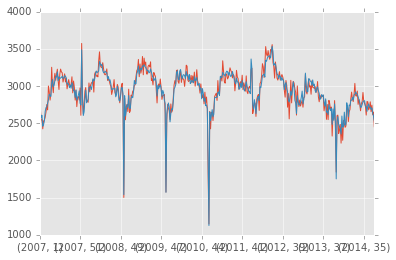

In [28]:
weekly_df['count'].plot()
weekly_df['final_prediction'].plot()

In [29]:
#Aggregating predictions up to monthly level
month_df=for_ts.groupby(by=[for_ts.index.year, for_ts.index.month]).sum()
month_df['glm_mape']=abs((month_df['count']-month_df['glm_value'])/month_df['count'])
month_df['final_mape']=abs((month_df['count']-month_df['final_prediction'])/month_df['count'])

In [30]:
#GLM MAPE
sum(month_df['glm_mape'])/len(month_df['glm_mape'])*100

3.5369520413817974

In [31]:
#Full Mape
sum(month_df['final_mape'])/len(month_df['glm_mape'])*100

0.98094291894236296

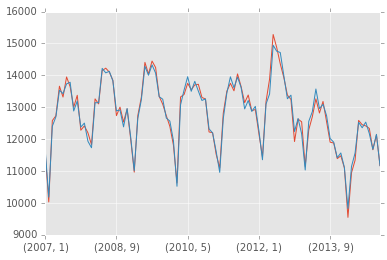

In [32]:
month_df['count'].plot()
month_df['final_prediction'].plot()

In [33]:
year_df=for_ts.groupby(by=[for_ts.index.year]).sum()
year_df['glm_mape']=abs((year_df['count']-year_df['glm_value'])/year_df['count'])
year_df['final_mape']=abs((year_df['count']-year_df['final_prediction'])/year_df['count'])

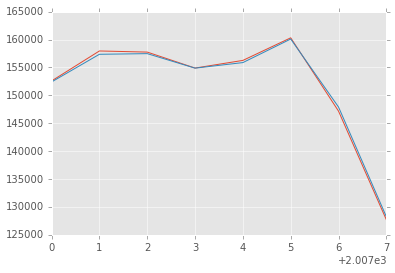

In [34]:
year_df['count'].plot()
year_df['final_prediction'].plot()

In [35]:
year_df

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
2007,-2233.229940,152569,154802.229940,9647,2382,732555,-2411.145516,152391.084423,177.915577,0.014638,0.001166
2008,3982.950277,157945,153962.049723,9648,2384,734928,3386.976027,157349.025750,595.974250,0.025217,0.003773
2009,4756.730163,157743,152986.269837,9855,2382,733285,4480.587420,157466.857256,276.142744,0.030155,0.001751
2010,1262.479300,154882,153619.520700,9701,2382,733650,1247.611844,154867.132544,14.867456,0.008151,0.000096
2011,2048.129800,156253,154204.870200,9698,2382,734015,1658.549342,155863.419541,389.580459,0.013108,0.002493
2012,6500.412574,160302,153801.587426,9699,2384,736392,6284.064524,160085.651949,216.348051,0.040551,0.001350
2013,-4235.203385,147154,151389.203385,9647,2382,734745,-3497.795934,147891.407451,-737.407451,0.028781,0.005011
2014,-12082.268791,127693,139775.268791,8230,2010,672676,-11542.013797,128233.254994,-540.254994,0.094620,0.004231


In [36]:
#Let's see why we did by comparing to our hold-out validation set -- the last month of the dataset
validation_data=pd.read_csv('durham_validation.csv')
#validation_data=validation_data.loc[0:180]
validation_data['date_received'] = pd.to_datetime(validation_data['date_received'])
validation_data.index=validation_data['date_received']
validation_data['constant']=1



#Dummy Variable for DOW
dow_dummies=pd.get_dummies(validation_data['dow_received'], prefix='dow')
dow_columns=list(dow_dummies.columns.values)
validation_data=validation_data.join(dow_dummies, how='left')

#Dummy Variable for month
month_dummies=pd.get_dummies(validation_data['month_received'], prefix='month')
month_columns=list(month_dummies.columns.values)
validation_data=validation_data.join(month_dummies, how='left')


#Dummy Variable for TMAX_CAT
tmax_dummies=pd.get_dummies(validation_data['apparentTemperatureMax_quartile'], prefix='tmax')
tmax_columns=list(tmax_dummies.columns.values)
validation_data=validation_data.join(tmax_dummies, how='left')

#Interaction Column
validation_data['pressure_wind']=validation_data['pressure_ln']*validation_data['windSpeed']

for column in glm_vars:
    if column not in validation_data.columns:
        validation_data[column]=0

In [37]:
validation_data['glm_forecast']=reg.predict(validation_data[glm_vars])
validation_data['arima_adjust']=ts_model_fit.forecast(steps=len(validation_data))[0]

In [38]:
validation_data['forecast']=validation_data['glm_forecast']+validation_data['arima_adjust']
final_weekly_forecast=validation_data.groupby(by=[validation_data.index.week]).sum()
final_monthly_forecast=validation_data.groupby(by=[validation_data.index.month]).sum()

In [39]:
validation_data['final_mape']=abs((validation_data['citizen_init_count']-validation_data['forecast'])/validation_data['citizen_init_count'])

In [40]:
#MAPE after GLM + ARMA
sum(validation_data['final_mape'])/len(validation_data['final_mape'])*100

6.90588973477624

In [51]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

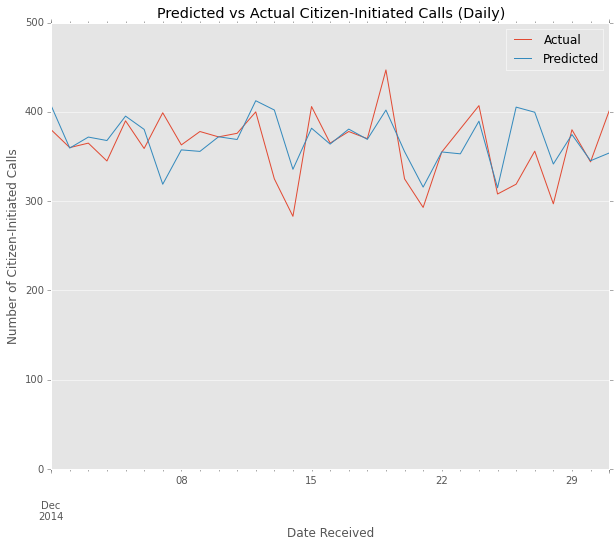

In [66]:
#Actuals vs. predicted
validation_data['citizen_init_count'].plot(title="Predicted vs Actual Citizen-Initiated Calls (Daily)", legend=True,
                                          label="Actual", ylim=(0, 500))
ax = validation_data['forecast'].plot(legend=True, label="Predicted")
ax.set_xlabel('Date Received')
ax.set_ylabel('Number of Citizen-Initiated Calls')

In [58]:
#Aggregating predictions up to weekly level
weekly_df=validation_data.groupby(by=[validation_data.index.year, validation_data.index.week]).sum()
weekly_df['final_mape']=abs((weekly_df['citizen_init_count']-weekly_df['forecast'])/weekly_df['citizen_init_count'])

In [59]:
sum(weekly_df['final_mape'])/len(weekly_df['final_mape'])*100

3.0339877470594336

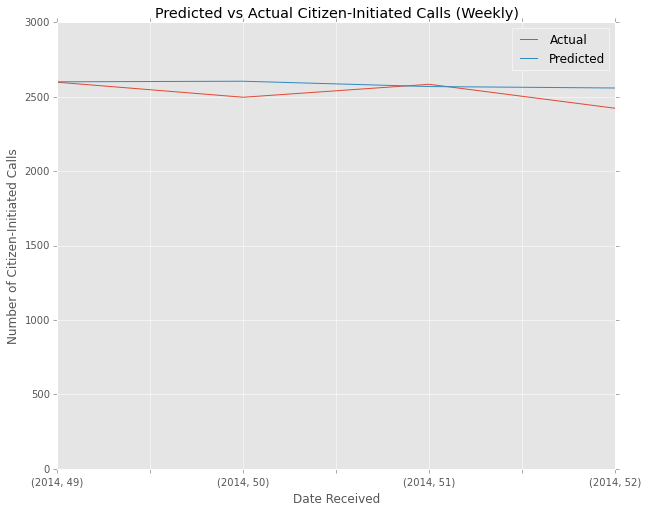

In [70]:
#Actuals vs. predicted
weekly_df['citizen_init_count'][1:].plot(title="Predicted vs Actual Citizen-Initiated Calls (Weekly)", legend=True,
                                          label="Actual", ylim=(0,3000))
ax = weekly_df['forecast'][1:].plot(legend=True, label="Predicted")
ax.set_xlabel('Date Received')
ax.set_ylabel('Number of Citizen-Initiated Calls')

In [154]:
#Aggregating predictions up to monthly level
monthly_df=validation_data.groupby(by=[validation_data.index.year, validation_data.index.month]).sum()
monthly_df['final_mape']=abs((monthly_df['citizen_init_count']-monthly_df['forecast'])/monthly_df['citizen_init_count'])
sum(monthly_df['final_mape'])/len(monthly_df['final_mape'])*100

1.6063943907654692

/Users/pruddle/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


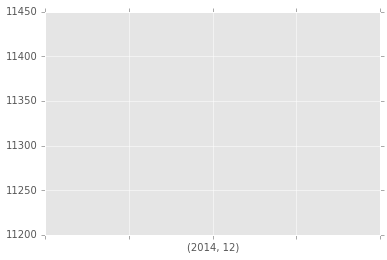

In [155]:
#Actuals vs. predicted
monthly_df['citizen_init_count'].plot()
monthly_df['forecast'].plot()

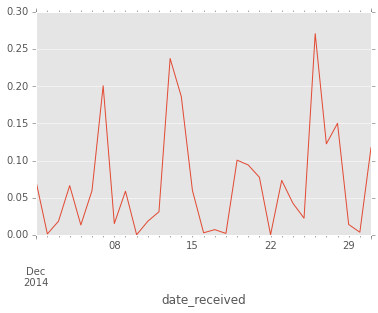

In [156]:
validation_data['final_mape'].plot()

In [57]:
yearly_df=validation_data.groupby(by=[validation_data.index.year]).sum()

In [58]:
yearly_df

,citizen_init_count,officer_init_count,year_received,month_received,week_received,day_received,dow_received,apparentTemperatureMax,apparentTemperatureMin,cloudCover,...,month_12,tmax_1,tmax_2,tmax_3,tmax_4,pressure_wind,glm_forecast,arima_adjust,forecast,final_mape
2014,138920,149413,735110,2382,9647,5738,1094,24976.18,17186.96,64.42,...,31,105,83,100,77,12332.290089,153870.17475,-6012.100201,147858.074549,32.635165


In [59]:
validation_data

,date_received,citizen_init_count,officer_init_count,year_received,month_received,week_received,day_received,dow_received,apparentTemperatureMax,apparentTemperatureMin,...,month_12,tmax_1,tmax_2,tmax_3,tmax_4,pressure_wind,glm_forecast,arima_adjust,forecast,final_mape
date_received,,,,,,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,431,397,2014,1,1,1,2,47.19,25.38,...,0,1,0,0,0,18.239589,378.041164,-22.663406,355.377757,0.175458
2014-01-02,2014-01-02,330,521,2014,1,1,2,3,45.05,35.69,...,0,1,0,0,0,17.437803,377.137943,-26.049435,351.088508,0.063905
2014-01-03,2014-01-03,473,483,2014,1,1,3,4,34.98,11.78,...,0,1,0,0,0,69.719991,402.991495,-26.348855,376.642640,0.203715
2014-01-04,2014-01-04,300,386,2014,1,1,4,5,35.27,9.38,...,0,1,0,0,0,16.376708,376.305401,-26.309200,349.996201,0.166654
2014-01-05,2014-01-05,309,354,2014,1,1,5,6,54.52,32.73,...,0,1,0,0,0,9.836840,339.331928,-26.232531,313.099397,0.013267
2014-01-06,2014-01-06,373,462,2014,1,2,6,0,59.32,3.48,...,0,0,1,0,0,66.067492,421.553533,-26.152056,395.401478,0.060058
2014-01-07,2014-01-07,352,593,2014,1,2,7,1,15.79,-4.12,...,0,1,0,0,0,48.218987,346.080425,-26.071424,320.009001,0.090884
2014-01-08,2014-01-08,364,574,2014,1,2,8,2,38.31,7.94,...,0,1,0,0,0,24.992147,368.277106,-25.991036,342.286070,0.059654
2014-01-09,2014-01-09,351,582,2014,1,2,9,3,51.69,25.02,...,0,1,0,0,0,16.174482,387.362672,-25.910935,361.451737,0.029777
